# Homework 1 - Group A 15

## FINM 37500: Fixed Income Derivatives

### Mark Hendricks

#### Winter 2024

- Zak Mehdi
- Daniel Nakamura
- Aurora Yang

# Context

For use in these problems, consider the data below, discussed in Veronesi's *Fixed Income Securities* Chapters 9, 10.
* interest-rate tree
* current term structure

In [39]:
import numpy as np
import pandas as pd
import datetime
import warnings
from scipy.optimize import fsolve

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.rcParams['figure.figsize'] = (12,6)
plt.rcParams['font.size'] = 15
plt.rcParams['legend.fontsize'] = 13

from matplotlib.ticker import (MultipleLocator,
                               FormatStrFormatter,
                               AutoMinorLocator)

import sys
sys.path.insert(0, '../cmds')
from binomial import *

In [40]:
rate_tree = pd.DataFrame({'0':[.0174,np.nan],'0.5':[.0339,.0095]})
rate_tree.columns.name = 'time $t$'
rate_tree.index.name = 'node'
rate_tree.style.format('{:.2%}',na_rep='')

time $t$,0,0.5
node,,
0,1.74%,3.39%
1,,0.95%


The "tree" is displayed as a pandas dataframe, so it does not list "up" and "down" for the rows but rather an index of nodes. The meaning should be clear.

In [41]:
term_struct = pd.DataFrame({'maturity':[.5,1,1.5],'price':[99.1338,97.8925,96.1462]})
term_struct['continuous ytm'] = -np.log(term_struct['price']/100) / term_struct['maturity']
term_struct.set_index('maturity',inplace=True)
term_struct.style.format({'price':'{:.4f}','continuous ytm':'{:.2%}'}).format_index('{:.1f}')

,price,continuous ytm
maturity,,
0.5,99.1338,1.74%
1.0,97.8925,2.13%
1.5,96.1462,2.62%


This is the current term-structure observed at $t=0$.

# 1. Pricing a Swap

### 1.1 
Calculate the tree of bond prices for the 2-period, $T=1$, bond.

In [42]:
FACE = 100
MATUND = 1

bond_tree = pd.DataFrame(index=rate_tree.index, columns=rate_tree.columns.astype(float))

rate_tree.columns = rate_tree.columns.astype(float)

for i in bond_tree.columns[::-1]:
        bond_tree[i] = np.exp(-rate_tree[i] * (MATUND - i)) * FACE

bond_tree.iloc[0,0] = term_struct.loc[MATUND, 'price']

bond_tree

time $t$,0.0,0.5
node,,
0,97.8925,98.319284
1,NaN,99.526126


### 1.2 
What is the risk-neutral probability of an upward movement of interest rates at $t=.5$?

## The option contract

Consider a single-period swap that pays at time period 1 ($t=0.5$), the expiration payoff (and thus terminal value) is
* Payoff = $\frac{100}{2}(r_1 −c)$
* with $c=2\%$
* payments are semiannual

Take the viewpoint of a fixed-rate payer, floating rate receiver.

In [43]:
r0 = rate_tree.loc[0, 0.0]  

bond_price_at_1 = term_struct.loc[1.0, 'price']  

dt = 0.5
A = np.exp(dt * r0)
Z = np.exp(-dt * r0)
price_node_0 = bond_tree.loc[0, 0.5]  
price_node_1 = bond_tree.loc[1, 0.5]  

P1_2 = [price_node_0, price_node_1]

# Calculate risk-neutral probability
pstar = (A * bond_price_at_1 - P1_2[1]) / (P1_2[0] - P1_2[1])

rnpricing = pd.DataFrame(index=['up', 'down'], columns=['probability'], dtype=float)
rnpricing.loc['up', 'probability'] = pstar
rnpricing.loc['down', 'probability'] = 1 - pstar

rnpricing

,probability
up,0.644862
down,0.355138


In [44]:
c = 0.02 
payoff = lambda r: (FACE / 2) * (r - c)

swap_tree = pd.DataFrame(index=rate_tree.index, columns=rate_tree.columns, dtype=float)
swap_tree[dt] = payoff(rate_tree[dt])

### 1.3 
What is the replicating trade using the two bonds (period 1 and period 2)?

In [45]:
def replicating_port(quotes, undertree, derivtree, dt=None, Ncash=100):
    """
    Calculates the positions and values of a replicating portfolio.

    Parameters:
    quotes (array-like): The quotes for the derivative instrument.
    undertree (DataFrame): The price tree for the underlying asset.
    derivtree (DataFrame): The price tree for the derivative instrument.
    dt (float, optional): The time step size. If not provided, it is calculated from the undertree.
    Ncash (float, optional): The amount of cash to invest. Default is 100.

    Returns:
    DataFrame: A DataFrame containing the positions and values of the replicating portfolio.
    """

    if dt is None:
        dt = undertree.columns[1] - undertree.columns[0]
    
    delta = (derivtree.loc[0, dt] - derivtree.loc[1, dt]) / (undertree.loc[0, dt] - undertree.loc[1, dt]) 
    cash = (derivtree.loc[0, dt] - delta * undertree.loc[0, dt]) / Ncash
    
    out = pd.DataFrame({'positions': [cash, delta], 'value': quotes}, index=['cash', 'under'])
    out.loc['derivative', 'value'] = out['positions'] @ out['value']
    return out

In [46]:
replicating_trad = replicating_port(term_struct.loc[[.5,1],'price'].values, bond_tree, swap_tree)
replicating_trad

,positions,value
cash,1.000862,99.13380
under,-1.010903,97.89250
derivative,NaN,0.25949


### 1.4 
What is the price of the swap?

In [47]:
swap_tree.loc[0,0] = Z * np.array([pstar,1-pstar])@ swap_tree[dt].values
swap_tree

time $t$,0.0,0.5
node,,
0,0.259464,0.695
1,NaN,-0.525


# 2. Using the Swap as the Underlying
As in the note, W.1, consider pricing the followign interest-rate option,
* Payoff is $100\max(r_K-r_1,0)$
* strike is $r_K$ is 2\%
* expires at period 1, ($t=0.5$) 

Unlike the note, price it with the swap used as the underlying, not the two-period ($t=1$) bond. You will once again use the period-1 ($t=0.5$) bond as the cash account for the no-arbitrage pricing.

So instead of replicating the option with the two treasuries, now you're replicating/pricing it with a one-period bond and two-period swap.

### 2.1
Display the tree of swap prices.

In [48]:
swap_tree

time $t$,0.0,0.5
node,,
0,0.259464,0.695
1,NaN,-0.525


### 2.2
What is the risk-neutral probability of an upward movement at $t=.5$ implied by the underlying swap tree? 

Is this the same as the risk-neutral probability we found when the bond was used as the underlying?

In [49]:
def estimate_pstar(quotes, ratetree, style='european'):
    """
    Estimates the pstar values for each time step in the ratetree.

    Parameters:
    - quotes (DataFrame): DataFrame containing the bond quotes.
    - ratetree (DataFrame): DataFrame representing the interest rate tree.
    - style (str, optional): The style of the bond option. Defaults to 'european'.

    Returns:
    - pstars (Series): Series containing the estimated pstar values for each time step.
    """

    pstars = pd.Series(dtype=float, index=ratetree.columns[:-1], name='pstar')
    p0 = .5
    
    for steps_forward, t in enumerate(ratetree.columns[1:]):        
        ratetreeT = ratetree.copy().loc[:,:t].dropna(axis=0,how='all')
        t_prev = ratetreeT.columns[steps_forward]
        
        pstars_solved = pstars.loc[:t_prev].iloc[:-1]
        wrapper_fun = lambda p: bond_price_error(quotes['price'].iloc[steps_forward+1], pd.concat([pstars_solved, pd.Series(p,index=[t_prev])]), ratetreeT, style=style)

        pstars[t_prev] = fsolve(wrapper_fun,p0)[0]

    return pstars

def bond_price_error(quote, pstars, ratetree, style='european'):
    """
    Calculates the error between the model price and the given quote for a bond.

    Parameters:
    quote (float): The quoted price of the bond.
    pstars (list): List of probabilities for each node in the rate tree.
    ratetree (DataFrame): DataFrame representing the rate tree.
    style (str, optional): The style of the bond option. Defaults to 'european'.

    Returns:
    float: The error between the model price and the quote.
    """
    FACEVALUE = 100
    dt = ratetree.columns[1] - ratetree.columns[0]    
    payoff = lambda r: payoff_bond(r,dt)
    modelprice = bintree_pricing(payoff, ratetree, pstars=pstars, style=style).loc[0,0]
    error = modelprice - quote

    return error

def bintree_pricing_old(payoff=None, ratetree=None, undertree=None, cftree=None, pstars=None, timing=None, style='european'):
    """
    Calculates the pricing of a derivative using a binomial tree model.

    Parameters:
    - payoff (function): The payoff function of the derivative. Default is None.
    - ratetree (DataFrame): The interest rate tree. Default is None.
    - undertree (DataFrame): The underlying asset tree. Default is None.
    - cftree (DataFrame): The cash flow tree. Default is None.
    - pstars (Series): The probability tree. Default is None.
    - timing (str): The timing of the derivative. Default is None.
    - style (str): The style of the derivative. Default is 'european'.

    Returns:
    - valuetree (DataFrame): The tree of derivative values.
    """

    if payoff is None:
        payoff = lambda r: payoff_bond(r, dt)

    if undertree is None:
        undertree = ratetree

    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)

    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if undertree.columns.to_series().diff().std() > 1e-5:
        display('time grid is unevenly spaced')
    dt = undertree.columns[1] - undertree.columns[0]

    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back == 0:
            valuetree[t] = payoff(undertree[t])
            if timing == 'deferred':
                valuetree[t] *= np.exp(-ratetree[t] * dt)
        else:
            for state in valuetree[t].index[:-1]:
                valuetree.loc[state, t] = np.exp(-ratetree.loc[state, t] * dt) * (
                            pstars[t] * valuetree.iloc[state, -steps_back] + (1 - pstars[t]) * valuetree.iloc[
                        state + 1, -steps_back] + cftree.loc[state, t])

            if style == 'american':
                valuetree.loc[:, t] = np.maximum(valuetree.loc[:, t],
                                                 payoff(undertree.loc[:, t]) + np.exp(-ratetree.loc[:, t] * dt) *
                                                 cftree.loc[:, t])

    return valuetree

def format_bintree(df, style='{:.2f}'):
    """
    Formats a binary tree DataFrame with a given style.

    Parameters:
    - df (pandas.DataFrame): The binary tree DataFrame to be formatted.
    - style (str, optional): The formatting style to be applied. Defaults to '{:.2f}'.

    Returns:
    - pandas.io.formats.style.Styler: The formatted binary tree DataFrame.
    """
    return df.style.format(style, na_rep='').format_index('{:.2f}', axis=1)

In [50]:
pstars = estimate_pstar(term_struct.loc[:rate_tree.index[-1],['price']], rate_tree)
format_bintree(pstars.to_frame().T, style='{:.2%}')

time $t$,0.00
pstar,64.49%


### 2.3
What is the price of the rate option? Is it the same as we calculated in the note, W.1.?

In [51]:
FACE = 100
EXPIRATION = 0.5
STRIKE = 0.02
payoff = lambda r: FACE * np.maximum(STRIKE - r, 0)

floorlet_tree = pd.DataFrame(dtype=float, columns=rate_tree.columns, index=rate_tree.index)
floorlet_tree[EXPIRATION] = payoff(rate_tree[EXPIRATION])
floorlet_tree.loc[0,0] = Z * np.array([pstar, 1-pstar])@floorlet_tree[EXPIRATION].values
format_bintree(floorlet_tree,style='{:.4f}')


time $t$,0.00,0.50
node,,
0,0.3697,0.0000
1,,1.0500


# 3. Pricing a Call on a Bond

Try using the same tree to price a call on the period-2 bond, (1-year), at period 1 (6-months).
* Payoff = $\max(P_{1|2}-K,0)$
* Strike = \$99.00

### 3.1 
What is the replicating trade using the two bonds (period 1 and period 2) as above? (That is, we are no longer using the swap as the underlying.)

In [52]:
def bintree_pricing(payoff=None, ratetree=None, undertree=None, cftree=None, dt=None, pstars=None, timing=None, cfdelay=False, style='european', Tamerican=0):
    """
    Calculates the pricing of a derivative using a binomial tree model.

    Parameters:
    - payoff (function): The payoff function of the derivative. Default is None.
    - ratetree (DataFrame): The interest rate tree. Default is None.
    - undertree (DataFrame): The underlying asset price tree. Default is None.
    - cftree (DataFrame): The cash flow tree. Default is None.
    - dt (float): The time step size. Default is None.
    - pstars (Series): The probabilities of up movement in the tree. Default is None.
    - timing (str): The timing of cash flows. Default is None.
    - cfdelay (bool): Whether to delay cash flows. Default is False.
    - style (str): The style of the derivative. Default is 'european'.
    - Tamerican (float): The time at which the derivative can be exercised for American style. Default is 0.

    Returns:
    - valuetree (DataFrame): The tree of derivative values.
    """
    
    if payoff is None:
        payoff = lambda r: 0
    
    if undertree is None:
        undertree = ratetree
        
    if cftree is None:
        cftree = pd.DataFrame(0, index=undertree.index, columns=undertree.columns)
        
    if pstars is None:
        pstars = pd.Series(.5, index=undertree.columns)

    if dt is None:
        dt = undertree.columns.to_series().diff().mean()
        dt = undertree.columns[1]-undertree.columns[0]
    
    if timing == 'deferred':
        cfdelay = True
    
    if dt<.25 and cfdelay:
        display('Warning: cfdelay setting only delays by dt.')
        
    valuetree = pd.DataFrame(dtype=float, index=undertree.index, columns=undertree.columns)

    for steps_back, t in enumerate(valuetree.columns[-1::-1]):
        if steps_back==0:                           
            valuetree[t] = payoff(undertree[t])
            if cfdelay:
                valuetree[t] *= np.exp(-ratetree[t]*dt)
        else:
            for state in valuetree[t].index[:-1]:
                val_avg = pstars[t] * valuetree.iloc[state,-steps_back] + (1-pstars[t]) * valuetree.iloc[state+1,-steps_back]
                
                if cfdelay:
                    cf = cftree.loc[state,t]
                else:                    
                    cf = cftree.iloc[state,-steps_back]
                
                valuetree.loc[state,t] = np.exp(-ratetree.loc[state,t]*dt) * (val_avg + cf)

            if style=='american':
                if t>= Tamerican:
                    valuetree.loc[:,t] = np.maximum(valuetree.loc[:,t],payoff(undertree.loc[:,t]))
        
    return valuetree

In [53]:
STRIKE = 99
payoff = lambda p: np.maximum(p - STRIKE, 0)

dervitree = bintree_pricing(payoff, rate_tree, bond_tree, pstars=pstars)
replicating_port(term_struct.loc[[.5,1],'price'].values, bond_tree, dervitree)


,positions,value
cash,-0.428626,99.133800
under,0.435953,97.892500
derivative,NaN,0.185218


### 3.2 
What is the price of the European call option? 
* expiring at $T=.5$ 
* written on the bond maturing in 2 periods, ($t=1$)

In [54]:
format_bintree(dervitree,style='{:.4f}')

time $t$,0.00,0.50
node,,
0,0.1852,0.0000
1,,0.5261


# 4 Two-Period Tree

Consider an expanded, **2 period** tree. (Two periods of uncertainty, so with the starting point, three periods total.)

In [55]:
new_col = pd.Series([.05,.0256,.0011],name='1')
rate_tree_multi = pd.concat([rate_tree,new_col],ignore_index=True,axis=1)
rate_tree_multi.columns = pd.Series([0,0.5,1],name='time $t$')
rate_tree_multi.index.name = 'node'
rate_tree_multi.style.format('{:.2%}',na_rep='')

time $t$,0.000000,0.500000,1.000000
node,,,
0,1.74%,3.39%,5.00%
1,,0.95%,2.56%
2,,,0.11%


In [56]:
def payoff_bond(r, dt, facevalue=100):
    """
    Calculates the price of a bond given the interest rate and time to maturity.

    Parameters:
    r (float): The interest rate.
    dt (float): The time to maturity.
    facevalue (float, optional): The face value of the bond. Default is 100.

    Returns:
    float: The price of the bond.
    """
    price = np.exp(-r * dt) * facevalue
    return price

### 4.1

Calculate and show the tree of prices for the 3-period bond, $T=1.5$.

In [57]:
pstars = estimate_pstar(term_struct, rate_tree_multi)
dt = 0.5
payoff = lambda r: payoff_bond(r,dt)

bond_tree_multi = bintree_pricing(payoff, rate_tree_multi, pstars = pstars)
format_bintree(bond_tree_multi, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,96.1462,96.1426,97.5310
1,,98.5184,98.7282
2,,,99.9450


### 4.2
Report the risk-neutral probability of an up movement at $t=1$.

(The risk-neutral probability of an up movement at $t=0.5$ continues to be as you calculated in 2.3.

In [58]:
format_bintree(pstars.to_frame().T, style='{:.2%}')

time $t$,0.00,0.50
pstar,64.49%,78.69%


### 4.3
Calculate the price of the European **call** option?
* expiring at $T=1$ 
* written on the bond maturing in 3 periods, ($t=1.5$)

In [59]:
STRIKE = 99
call_payoff = lambda p: np.maximum(p - STRIKE, 0)

dervitree_multi = bintree_pricing(call_payoff, rate_tree_multi, undertree = bond_tree_multi, pstars=pstars, style='european')
format_bintree(dervitree_multi, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,0.0706,0.0000,0.0000
1,,0.2004,0.0000
2,,,0.9450


### 4.4
Consider a finer time grid. Let $dt$ in the tree now be 1/30 instead of 0.5.

Using this smaller time step, compute the $t=0$ price of the following option:
* option expires at $t=1$
* written on bond maturing at $t=1.5

In [60]:
def construct_rate_tree(dt,T):
    timegrid = pd.Series((np.arange(0,round(T/dt)+1)*dt).round(6),name='time',index=pd.Index(range(round(T/dt)+1),name='state'))
    tree = pd.DataFrame(dtype=float,columns=timegrid,index=timegrid.index)
    return tree

In [61]:
dt = 1/30
TMAT = 1.5

sigma = .30  #assumed volatility from past HW 
up = np.exp(sigma*np.sqrt(dt))
down = np.exp(-sigma*np.sqrt(dt))

ratetree_dense = construct_rate_tree(dt, TMAT-dt)
ratetree_dense.loc[0,0] = rate_tree.loc[0,0]

for tsteps in range(ratetree_dense.shape[1]-1):
    ratetree_dense.iloc[:,tsteps+1] = ratetree_dense.iloc[:,tsteps] * up        
    ratetree_dense.iloc[tsteps+1,tsteps+1] = ratetree_dense.iloc[tsteps,tsteps] * down

format_bintree(ratetree_dense,style='{:.2%}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%,16.44%,17.36%,18.34%,19.37%
1,,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%,16.44%,17.36%
2,,,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%,14.73%,15.56%
3,,,,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%,13.20%,13.95%
4,,,,,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%,11.83%,12.50%
5,,,,,,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%,10.61%,11.20%
6,,,,,,,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%,9.51%,10.04%
7,,,,,,,,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%,8.52%,9.00%
8,,,,,,,,,1.12%,1.19%,1.25%,1.32%,1.40%,1.48%,1.56%,1.65%,1.74%,1.84%,1.94%,2.05%,2.17%,2.29%,2.42%,2.55%,2.70%,2.85%,3.01%,3.18%,3.36%,3.55%,3.75%,3.96%,4.18%,4.42%,4.66%,4.93%,5.20%,5.50%,5.81%,6.13%,6.48%,6.84%,7.23%,7.63%,8.06%


In [62]:
pstars = pd.Series(.6449, index=ratetree_dense.columns, name='pstar') #assumption made with pstar found in part 2,3, and 4
format_bintree(pstars.to_frame().T,style='{:.2%}')
new_payoff = lambda r: payoff_bond(r,dt)
bondtree_dense = bintree_pricing(new_payoff, ratetree_dense, pstars = pstars)

call_derivtree_dense = bintree_pricing(call_payoff, ratetree=ratetree_dense, undertree = bondtree_dense, pstars=pstars)
format_bintree(call_derivtree_dense, style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00,1.03,1.07,1.10,1.13,1.17,1.20,1.23,1.27,1.30,1.33,1.37,1.40,1.43,1.47
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.8441,0.8388,0.8334,0.8278,0.8220,0.8161,0.8100,0.8037,0.7972,0.7905,0.7836,0.7764,0.7691,0.7615,0.7537,0.7457,0.7374,0.7289,0.7201,0.7111,0.7017,0.6921,0.6822,0.6720,0.6614,0.6506,0.6394,0.6278,0.6159,0.6035,0.5908,0.5777,0.5641,0.5500,0.5355,0.5205,0.5049,0.4887,0.4720,0.4546,0.4365,0.4177,0.3981,0.3777,0.3563
1,,0.8550,0.8501,0.8451,0.8399,0.8345,0.8290,0.8233,0.8174,0.8114,0.8051,0.7987,0.7921,0.7853,0.7782,0.7710,0.7635,0.7558,0.7479,0.7397,0.7313,0.7226,0.7137,0.7045,0.6950,0.6852,0.6751,0.6647,0.6540,0.6429,0.6315,0.6197,0.6075,0.5949,0.5819,0.5685,0.5546,0.5402,0.5252,0.5098,0.4937,0.4771,0.4597,0.4417,0.4229
2,,,0.8652,0.8606,0.8560,0.8511,0.8461,0.8410,0.8357,0.8303,0.8246,0.8188,0.8129,0.8067,0.8004,0.7938,0.7871,0.7802,0.7730,0.7657,0.7581,0.7503,0.7422,0.7339,0.7254,0.7166,0.7075,0.6981,0.6885,0.6785,0.6683,0.6577,0.6468,0.6355,0.6239,0.6118,0.5994,0.5866,0.5733,0.5595,0.5452,0.5305,0.5151,0.4992,0.4826
3,,,,0.8747,0.8705,0.8661,0.8616,0.8570,0.8522,0.8473,0.8423,0.8370,0.8317,0.8261,0.8204,0.8145,0.8084,0.8022,0.7958,0.7891,0.7823,0.7752,0.7680,0.7605,0.7528,0.7449,0.7368,0.7283,0.7197,0.7107,0.7015,0.6920,0.6822,0.6721,0.6617,0.6510,0.6399,0.6284,0.6166,0.6043,0.5916,0.5785,0.5649,0.5508,0.5362
4,,,,,0.8836,0.8797,0.8756,0.8714,0.8672,0.8627,0.8582,0.8535,0.8486,0.8436,0.8385,0.8332,0.8277,0.8221,0.8163,0.8103,0.8042,0.7978,0.7913,0.7846,0.7777,0.7705,0.7632,0.7556,0.7478,0.7398,0.7316,0.7230,0.7143,0.7052,0.6959,0.6863,0.6764,0.6661,0.6555,0.6446,0.6334,0.6217,0.6096,0.5971,0.5842
5,,,,,,0.8919,0.8882,0.8845,0.8806,0.8766,0.8725,0.8683,0.8639,0.8594,0.8548,0.8500,0.8451,0.8400,0.8348,0.8294,0.8239,0.8182,0.8123,0.8063,0.8001,0.7937,0.7871,0.7803,0.7733,0.7661,0.7587,0.7510,0.7431,0.7350,0.7267,0.7181,0.7092,0.7001,0.6906,0.6809,0.6709,0.6605,0.6498,0.6387,0.6273
6,,,,,,,0.8996,0.8962,0.8927,0.8891,0.8854,0.8816,0.8777,0.8736,0.8695,0.8652,0.8608,0.8562,0.8515,0.8467,0.8417,0.8366,0.8313,0.8259,0.8203,0.8145,0.8086,0.8025,0.7962,0.7897,0.7831,0.7762,0.7692,0.7619,0.7544,0.7467,0.7388,0.7306,0.7222,0.7135,0.7046,0.6954,0.6859,0.6760,0.6659
7,,,,,,,,0.9068,0.9036,0.9004,0.8971,0.8936,0.8901,0.8865,0.8827,0.8789,0.8749,0.8708,0.8666,0.8622,0.8577,0.8531,0.8484,0.8435,0.8385,0.8333,0.8280,0.8225,0.8169,0.8111,0.8051,0.7990,0.7926,0.7861,0.7794,0.7725,0.7655,0.7581,0.7506,0.7429,0.7349,0.7267,0.7182,0.7095,0.7005
8,,,,,,,,,0.9134,0.9105,0.9076,0.9045,0.9013,0.8980,0.8947,0.8912,0.8876,0.8839,0.8801,0.8762,0.8722,0.8681,0.8638,0.8594,0.8549,0.8502,0.8455,0.8405,0.8355,0.8303,0.8249,0.8194,0.8137,0.8079,0.8019,0.7958,0.7894,0.7829,0.7762,0.7693,0.7621,0.7548,0.7473,0.7395,0.7315


# 5 American Style
### 5.1
Use the two-period tree from part 4, but this time to price an American-style **put** option.

Use a grid of $dt=.5$.
* What is its value at $t=0$?
* Which nodes would you exercise it early?

In [63]:
dt = .5
STRIKE = 99
put_payoff = lambda p: np.maximum(STRIKE-p,0)

put_derivtree = bintree_pricing(put_payoff, rate_tree_multi, bond_tree_multi, pstars=pstars, style='american')
format_bintree(put_derivtree, style='{:.4f}')

time $t$,0.00,0.50,1.00
node,,,
0,2.8538,2.8574,1.4690
1,,0.4816,0.2718
2,,,0.0000


In [64]:
def exercise_decisions(payoff, undertree, derivtree):
    """
    Determines the exercise decisions for a derivative based on the payoff function, the underlying tree, and the derivative tree.

    Parameters:
    - payoff (function): The payoff function that calculates the derivative's payoff based on the underlying tree.
    - undertree (array-like): The underlying tree.
    - derivtree (array-like): The derivative tree.

    Returns:
    - exer (array-like): A boolean array indicating the exercise decisions for the derivative.
    """
    exer = (derivtree == payoff(undertree)) & (derivtree > 0)
    return exer

In [65]:
exercise_decisions(put_payoff, bond_tree_multi, put_derivtree)   

time $t$,0.0,0.5,1.0
node,,,
0,True,True,True
1,False,True,True
2,False,False,False


### 5.2
Change the grid to $dt=1/30$, as in 4.4. 
* What is its value at $t=0$?
* Make a visualization showing which nodes have early exercise. (I suggest using a dataframe and the `heatmap` from `seaborn`.

In [66]:
EXPIRATION = 1

In [67]:
#bondtree_dense = bintree_pricing(new_payoff, ratetree_dense, pstars = pstars)
#format_bintree(bondtree_dense,style='{:.4f}')

put_am_derivtree_dense = bintree_pricing(put_payoff, ratetree_dense.loc[:,:EXPIRATION], undertree=bondtree_dense.loc[:,:EXPIRATION], pstars=pstars, style='american')
format_bintree(put_am_derivtree_dense, style='{:.4f}')

time,0.00,0.03,0.07,0.10,0.13,0.17,0.20,0.23,0.27,0.30,0.33,0.37,0.40,0.43,0.47,0.50,0.53,0.57,0.60,0.63,0.67,0.70,0.73,0.77,0.80,0.83,0.87,0.90,0.93,0.97,1.00
state,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,2.8304,2.9162,3.0019,3.0875,3.1726,3.2570,3.3406,3.4231,3.5041,3.5835,3.6608,3.7357,3.8078,3.8768,3.9421,4.0034,4.0600,4.1115,4.1571,4.1964,4.2285,4.2528,4.2684,4.2744,4.2700,4.2540,4.2255,4.1833,4.1261,4.0525,3.9611
1,,2.5174,2.5946,2.6716,2.7482,2.8242,2.8995,2.9737,3.0467,3.1182,3.1878,3.2553,3.3203,3.3824,3.4413,3.4964,3.5475,3.5938,3.6350,3.6703,3.6993,3.7211,3.7352,3.7406,3.7366,3.7222,3.6965,3.6584,3.6068,3.5405,3.4581
2,,,2.2280,2.2973,2.3662,2.4346,2.5024,2.5692,2.6349,2.6992,2.7619,2.8226,2.8811,2.9371,2.9901,3.0397,3.0857,3.1274,3.1645,3.1963,3.2224,3.2421,3.2547,3.2596,3.2559,3.2430,3.2198,3.1855,3.1390,3.0793,3.0051
3,,,,1.9605,2.0225,2.0840,2.1450,2.2051,2.2642,2.3221,2.3784,2.4331,2.4858,2.5361,2.5838,2.6285,2.6699,2.7074,2.7408,2.7694,2.7929,2.8106,2.8220,2.8264,2.8231,2.8114,2.7905,2.7596,2.7178,2.6640,2.5972
4,,,,,1.7134,1.7687,1.8235,1.8776,1.9307,1.9827,2.0335,2.0826,2.1300,2.1753,2.2182,2.2584,2.2956,2.3294,2.3594,2.3852,2.4063,2.4222,2.4324,2.4364,2.4334,2.4229,2.4041,2.3763,2.3387,2.2902,2.2301
5,,,,,,1.4852,1.5344,1.5830,1.6308,1.6776,1.7232,1.7674,1.8100,1.8507,1.8893,1.9255,1.9589,1.9893,2.0163,2.0395,2.0585,2.0728,2.0820,2.0855,2.0828,2.0734,2.0565,2.0315,1.9976,1.9540,1.9000
6,,,,,,,1.2746,1.3183,1.3612,1.4033,1.4443,1.4840,1.5223,1.5589,1.5936,1.6261,1.6561,1.6835,1.7077,1.7286,1.7456,1.7585,1.7668,1.7699,1.7675,1.7590,1.7438,1.7213,1.6908,1.6517,1.6031
7,,,,,,,,1.0804,1.1189,1.1567,1.1935,1.2292,1.2636,1.2965,1.3277,1.3569,1.3839,1.4085,1.4303,1.4490,1.4644,1.4759,1.4834,1.4862,1.4840,1.4764,1.4627,1.4425,1.4151,1.3799,1.3362
8,,,,,,,,,0.9013,0.9352,0.9683,1.0004,1.0313,1.0608,1.0888,1.1151,1.1393,1.1614,1.1810,1.1978,1.2116,1.2220,1.2286,1.2312,1.2293,1.2224,1.2101,1.1919,1.1673,1.1357,1.0964


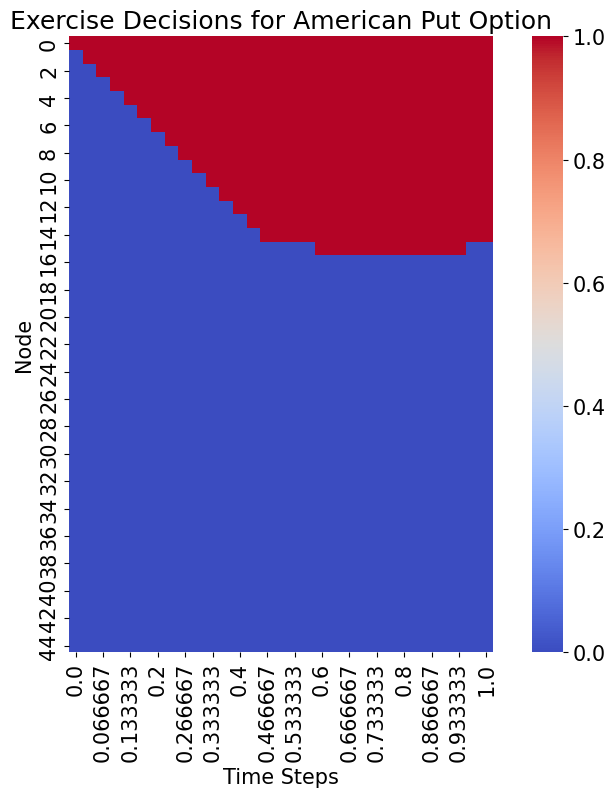

In [68]:
decisions_matrix = exercise_decisions(put_payoff, bondtree_dense.loc[:,:EXPIRATION], put_am_derivtree_dense)

plt.figure(figsize=(10, 8)) 
sns.heatmap(decisions_matrix, square=True, cmap='coolwarm', cbar=True)
plt.title('Exercise Decisions for American Put Option')
plt.xlabel('Time Steps')
plt.ylabel('Node')
plt.show()